This notebook is used to illustrate the example of using PyTorch for 1D regression problem with `california_housing` dataset.

# Preprocessing

In [1]:
# import libraries
import functools
import logging
import os
from datetime import datetime

# define logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
os.environ["RAY_DEDUP_LOGS"] = "0"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch
from ray import train, tune
from sklearn import datasets, model_selection, preprocessing
from torch import nn
from torch.utils import data

sns.set_style("darkgrid")

In [2]:
# define parameters
test_size = 0.15
random_state = 10

num_cpus = 6
loss_fn = nn.MSELoss()
epochs = 200
num_candidates = 10
early_stopping = 10

In [3]:
# fix notebook random seed
np.random.seed(random_state)
random.seed(random_state)
torch.manual_seed(random_state)

In [4]:
# fetch utils tools
%run utils/utils.ipynb
# fetch network pool
%run utils/model_pipe.ipynb

Load EarlyStopper
Load DNN1DNet model
Load CNN1DNet model
Load classifier train function
Load regression train function


# Data Downloading

In [5]:
# download example data
train_test = datasets.fetch_california_housing(
    data_home="../data/",
    download_if_missing=True,
    return_X_y=True,
)

In [6]:
# split into train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    train_test[0],
    train_test[1].reshape(-1, 1),
    test_size=test_size,
    random_state=random_state,
)

print(f"The shape of train dataset: {X_train.shape}")
print(f"The shapa of test dataset: {X_test.shape}")

The shape of train dataset: (17544, 8)
The shapa of test dataset: (3096, 8)


# Feature Engineering/Transformation

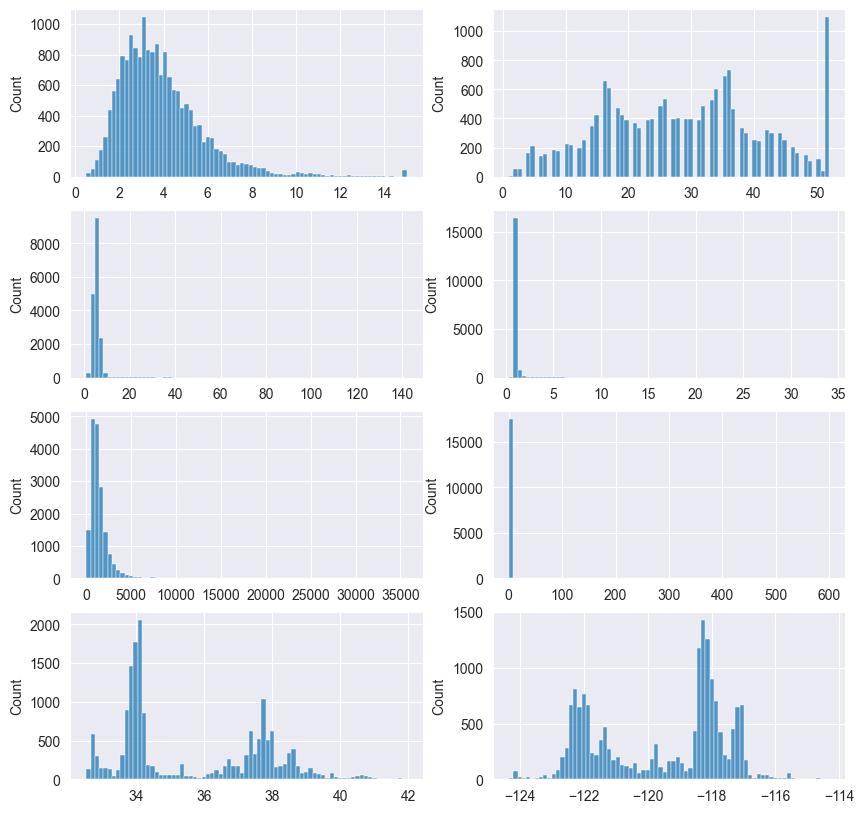

In [7]:
# feature distributions
_, axes = plt.subplots(4, 2, figsize=(10, 10), sharey=False)
for i in range(X_train.shape[1]):
    sns.histplot(X_train[:, i], ax=axes[i // 2, i % 2], bins=75)
plt.show()

In [8]:
# feature normalization
right_skewed = [0, 2, 3, 4, 5]

for col in right_skewed:
    X_train[:, col] = np.log(X_train[:, col])
    X_test[:, col] = np.log(X_test[:, col])

# feature rescaling
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

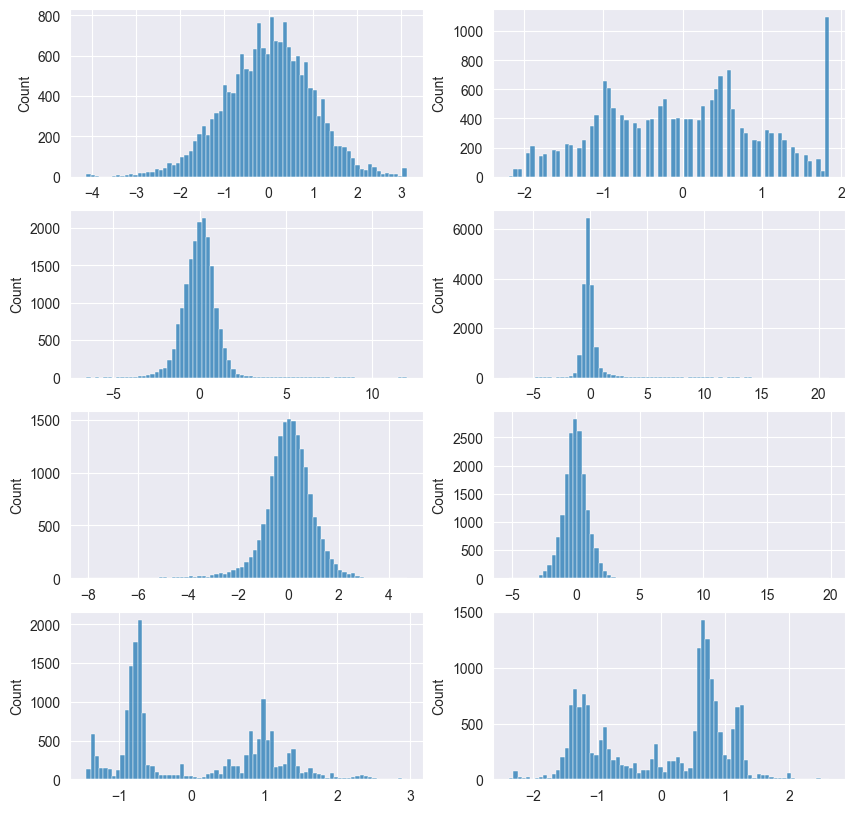

In [9]:
_, axes = plt.subplots(4, 2, figsize=(10, 10), sharey=False)
for i in range(X_train_scaled.shape[1]):
    sns.histplot(X_train_scaled[:, i], ax=axes[i // 2, i % 2], bins=75)
plt.show()

In [10]:
# create Tensor Dataset
train_dataset = data.TensorDataset(
    torch.from_numpy(X_train_scaled)
    .to(torch.float32)
    .view(X_train_scaled.shape[0], 1, -1),
    torch.from_numpy(y_train).to(torch.float32),
)
test_dataset = data.TensorDataset(
    torch.from_numpy(X_test_scaled)
    .to(torch.float32)
    .view(X_test_scaled.shape[0], 1, -1),
    torch.from_numpy(y_test).to(torch.float32),
)
print(f"The shape of the train feature: {train_dataset[:][0].shape}")
print(f"The shape of the test feature: {test_dataset[:][0].shape}")

The shape of the train feature: torch.Size([17544, 1, 8])
The shape of the test feature: torch.Size([3096, 1, 8])


# Model Training and Hyperparameter Tuning

## 1D DNN Model

In [11]:
# parameter grid for DNN model
config_dnn = {
    "model_parameters": {
        "hidden_layers": tune.choice(
            [
                [512, 256],
                [128, 128],
                [128, 128, 128],
                [128, 256, 128],
                [256, 512, 512, 256],
            ]
        )
    },
    "optimizer": tune.choice(["Adam", "SGD"]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([256, 512, 1024, 2048]),
}

In [12]:
# restart ray kernel
ray.shutdown()
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)
# define tuner
tuner_dnn = tune.Tuner(
    trainable=tune.with_resources(
        trainable=functools.partial(
            train_regressor,
            network_name="DNN1DNet",
            train_ray=ray.put(train_dataset),
            loss_fn=loss_fn,
            val_ray=None,
            val_size=test_size,
            last_checkpoint=None,
            num_workers=num_cpus,
            epochs=epochs,
            early_stopping=early_stopping,
            visual_batch=2000,
            verbose=0,
            random_state=random_state,
        ),
        resources={"cpu": 2},
    ),
    param_space=config_dnn,
    tune_config=tune.tune_config.TuneConfig(
        metric="loss",
        mode="min",
        scheduler=tune.schedulers.ASHAScheduler(
            max_t=1000,
            grace_period=1000,
            reduction_factor=2,
        ),
        num_samples=num_candidates,
    ),
    run_config=ray.air.config.RunConfig(
        name=f"example_california_1d_dnn_{datetime.now().strftime('%Y%m%d')}",
        storage_path=None,
        verbose=1,
    ),
)

2024-03-15 21:16:05,522	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
(func pid=93642) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/ywang/ray_results/example_california_1d_dnn_20240315/train_regressor_da758_00000_0_batch_size=256,lr=0.0001,hidden_layers=128_128,optimizer=SGD_2024-03-15_21-16-05/checkpoint_000000)
(func pid=93644) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/ywang/ray_results/example_california_1d_dnn_20240315/train_regressor_da758_00002_2_batch_size=256,lr=0.0003,hidden_layers=512_256,optimizer=SGD_2024-03-15_21-16-05/checkpoint_000000)
(func pid=93643) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/ywang/ray_results/example_california_1d_dnn_20240315/train_regressor_da758_00001_1_batch_size=512,lr=0.0056,hidden_layers=256_512_512_256,optimizer=SGD_2024-03-15_21-16-05/checkpoint_000000)
(func pid=93642) Checkpoint successfully creat

In [13]:
# hyperparameter tuning
results_dnn = tuner_dnn.fit()

2024-03-15 22:05:46,230	INFO tune.py:1042 -- Total run time: 2980.29 seconds (2980.26 seconds for the tuning loop).


In [14]:
# the best result
best_result_dnn = results_dnn.get_best_result("loss", "min")
print("Best trial config: {}".format(best_result_dnn.config))
print("Best trial final validation loss: {}".format(best_result_dnn.metrics["loss"]))
print("Best trial final validation MAE: {}".format(best_result_dnn.metrics["mae"]))
print("Best trial final validation R^2: {}".format(best_result_dnn.metrics["r2"]))

# the model with the best parameters and weights
best_model_dnn = DNN1DNet(
    usage="regression",
    input_size=train_dataset[0][0].shape[-1],
    output_size=train_dataset[0][1].shape[-1],
    **best_result_dnn.config["model_parameters"],
)
model_state_dnn = torch.load(
    os.path.join(best_result_dnn.checkpoint.to_directory(), "checkpoint.pt")
)["model_state"]
best_model_dnn.load_state_dict(model_state_dnn)
print(f"Model structure: {best_model_dnn}")

Best trial config: {'model_parameters': {'hidden_layers': [128, 256, 128]}, 'optimizer': 'Adam', 'lr': 0.0009900263803356115, 'batch_size': 512}
Best trial final validation loss: 0.26041436195373535
Best trial final validation MAE: 0.3460238575935364
Best trial final validation R^2: 0.8025254680816372
Model structure: DNN1DNet(
  (net): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear_0): Linear(in_features=8, out_features=128, bias=True)
    (norm_0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=128, out_features=256, bias=True)
    (norm_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=256, out_features=128, bias=True)
    (norm_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=128, out_feat

In [ ]:
# validation on test data
best_model_dnn.eval()
with torch.no_grad():
    test_pred_dnn = best_model_dnn(test_dataset[:][0])
    test_loss_dnn = loss_fn(test_pred_dnn, test_dataset[:][1]).item()

# metrics
mae_test_dnn = metrics.mean_absolute_error(
    test_dataset[:][1].numpy().flatten(),
    test_pred_dnn.detach().numpy().flatten(),
)
r2_test_dnn = metrics.r2_score(
    test_dataset[:][1].numpy().flatten(),
    test_pred_dnn.detach().numpy().flatten(),
)

In [ ]:
# remove temporary checkpoint files
!rm -rf f"{best_result_dnn.checkpoint.to_directory()}"

## 1D CNN Model

In [24]:
# parameter grid for DNN model
config_cnn = {
    "model_parameters": {
        "cnn_outputs": tune.choice(
            [
                [4, 4],
                [2, 2],
            ]
        ),
        "kernel_sizes": tune.choice([2]),
        "max_pools": tune.choice([2]),
        "linear_layers": tune.choice(
            [
                [512, 256],
                [128, 128],
                [128, 128, 128],
                [128, 256, 128],
                [256, 512, 512, 256],
            ]
        ),
    },
    "optimizer": tune.choice(["Adam", "SGD"]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([256, 512, 1024, 2048]),
}

In [25]:
# restart ray kernel
ray.shutdown()
ray.init(num_cpus=num_cpus, ignore_reinit_error=True)
# define tuner
tuner_cnn = tune.Tuner(
    trainable=tune.with_resources(
        trainable=functools.partial(
            train_regressor,
            network_name="CNN1DNet",
            train_ray=ray.put(train_dataset),
            loss_fn=loss_fn,
            val_ray=None,
            val_size=test_size,
            last_checkpoint=None,
            num_workers=num_cpus,
            epochs=epochs,
            early_stopping=early_stopping,
            visual_batch=2000,
            verbose=0,
            random_state=random_state,
        ),
        resources={"cpu": 2},
    ),
    param_space=config_cnn,
    tune_config=tune.tune_config.TuneConfig(
        metric="loss",
        mode="min",
        scheduler=tune.schedulers.ASHAScheduler(
            max_t=1000,
            grace_period=1000,
            reduction_factor=2,
        ),
        num_samples=num_candidates,
    ),
    run_config=ray.air.config.RunConfig(
        name=f"example_california_1d_cnn_{datetime.now().strftime('%Y%m%d')}",
        storage_path=None,
        verbose=1,
    ),
)

2024-03-16 09:22:38,153	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
(func pid=7829) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/ywang/ray_results/example_california_1d_cnn_20240316/train_regressor_59ab7_00002_2_batch_size=2048,lr=0.0099,cnn_outputs=4_4,kernel_sizes=2,linear_layers=128_256_128,max_pools=2,optim_2024-03-16_09-22-38/checkpoint_000000)
(func pid=7828) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/ywang/ray_results/example_california_1d_cnn_20240316/train_regressor_59ab7_00001_1_batch_size=1024,lr=0.0033,cnn_outputs=2_2,kernel_sizes=2,linear_layers=512_256,max_pools=2,optimizer_2024-03-16_09-22-38/checkpoint_000000)
(func pid=7827) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/ywang/ray_results/example_california_1d_cnn_20240316/train_regressor_59ab7_00000_0_batch_size=256,lr=0.0290,cnn_outputs=4_4,kernel_sizes=2,linear_layers=128_128

In [26]:
# hyperparameter tuning
results_cnn = tuner_cnn.fit()

2024-03-16 10:44:02,407	INFO tune.py:1042 -- Total run time: 4883.88 seconds (4883.85 seconds for the tuning loop).


In [ ]:
# the best result
best_result_cnn = results_cnn.get_best_result("loss", "min")
print("Best trial config: {}".format(best_result_cnn.config))
print("Best trial final validation loss: {}".format(best_result_cnn.metrics["loss"]))
print("Best trial final validation MAE: {}".format(best_result_cnn.metrics["mae"]))
print("Best trial final validation R^2: {}".format(best_result_cnn.metrics["r2"]))

# the model with the best parameters and weights
best_model_cnn = CNN1DNet(
    usage="regression",
    input_shape=(train_dataset[0][0].shape[-2], train_dataset[0][0].shape[-1]),
    output_size=train_dataset[0][1].shape[-1],
    **best_result_cnn.config["model_parameters"],
)
model_state_cnn = torch.load(
    os.path.join(best_result_cnn.checkpoint.to_directory(), "checkpoint.pt")
)["model_state"]
best_model_cnn.load_state_dict(model_state_cnn)
print(f"Model structure: {best_model_cnn}")

Best trial config: {'model_parameters': {'cnn_outputs': [4, 4], 'kernel_sizes': 2, 'max_pools': 2, 'linear_layers': [128, 256, 128]}, 'optimizer': 'Adam', 'lr': 0.009862031795177825, 'batch_size': 2048}
Best trial final validation loss: 0.5117067694664001
Best trial final validation MAE: 0.5233866572380066
Best trial final validation R^2: 0.6119682532662556
Model structure: CNN1DNet(
  (net): Sequential(
    (cnn_0): Conv1d(1, 4, kernel_size=(2,), stride=(1,))
    (norm_0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_0): ReLU()
    (maxpool_0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (cnn_1): Conv1d(4, 4, kernel_size=(2,), stride=(1,))
    (norm_1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_1): ReLU()
    (maxpool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fully_connection): Flatten(start_dim=1, end_dim=-1)
    (line

In [31]:
# validation on test data
best_model_cnn.eval()
with torch.no_grad():
    test_pred_cnn = best_model_cnn(test_dataset[:][0])
    test_loss_cnn = loss_fn(test_pred_cnn, test_dataset[:][1]).item()

# metrics
mae_test_cnn = metrics.mean_absolute_error(
    test_dataset[:][1].numpy().flatten(),
    test_pred_cnn.detach().numpy().flatten(),
)
r2_test_cnn = metrics.r2_score(
    test_dataset[:][1].numpy().flatten(),
    test_pred_cnn.detach().numpy().flatten(),
)

In [32]:
# remove temporary checkpoint files
!rm -rf f"{best_result_cnn.checkpoint.to_directory()}"

## Model Comparison

In [33]:
pd.DataFrame(
    {
        "Model": ["DNN-1D", "CNN-1D"],
        "Loss": [test_loss_dnn, test_loss_cnn],
        "MAE": [mae_test_dnn, mae_test_cnn],
        "R^2": [r2_test_dnn, r2_test_cnn],
    }
)

,Model,Loss,MAE,R^2
0,DNN-1D,0.276336,0.349048,0.795245
1,CNN-1D,0.549070,0.546326,0.593158
